In [61]:
#!/usr/bin/env python
#
# Simple DMRG tutorial.  This code contains a basic implementation of the
# infinite system algorithm
#
# Copyright 2013 James R. Garrison and Ryan V. Mishmash.
# Open source under the MIT license.  Source code at
# <https://github.com/simple-dmrg/simple-dmrg/>

# This code will run under any version of Python >= 2.6.  The following line
# provides consistency between python2 and python3.
from __future__ import print_function, division  # requires Python >= 2.6

# numpy and scipy imports
import numpy as np
from scipy.sparse import kron, identity, csr_matrix
from scipy.sparse.linalg import eigsh,eigs  # Lanczos routine from ARPACK
from scipy.linalg import eigh, norm, svd, eig
# We will use python's "namedtuple" to represent the Block and EnlargedBlock
# objects
from collections import namedtuple
import matplotlib.pyplot as plt

In [62]:
#system block
SysBlock = namedtuple("SysBlock", ["length", "basis_size", "operator_dict"])
EnlargedsysBlock = namedtuple("EnlargedsysBlock", ["length", "basis_size", "operator_dict"])

#env block
EnvBlock = namedtuple("EnvBlock", ["length", "basis_size", "operator_dict"])
EnlargedenvBlock = namedtuple("EnlargedenvBlock", ["length", "basis_size", "operator_dict"])

In [63]:
# Model-specific code for the Heisenberg XXZ chain
model_d = 2  # single-site basis size

Sz1 = 2*np.array([[0.5, 0], [0, -0.5]], dtype='d')  # single-site S^z
Sx1 = 2*np.array([[0, 0.5], [0.5, 0]], dtype='d')  # single-site S^x


In [64]:
def enlarge_sysblock(J,h,block):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict
    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        "H": kron(o["H"], identity(model_d)) +h*kron(identity(mblock),Sx1)+J*kron(o["conn_Sz"],Sz1),
        "Magz":kron(o["Magz"], identity(model_d)) + kron(identity(mblock),Sz1),
        "Magx":kron(o["Magx"], identity(model_d)) + kron(identity(mblock),Sx1),
        "conn_Sz": kron(identity(mblock), Sz1),
        "conn_Sx": kron(identity(mblock), Sx1),
    }

    return EnlargedsysBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)


In [65]:
def enlarge_envblock(J,h,block):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict
    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        #"H": kron(identity(model_d),o["H"])+h*kron(Sx1,identity(np.size(o["conn_Sx"],0)))+J*kron(Sz1,o["conn_Sz"]),
        "H": kron(identity(model_d),o["H"])+h*kron(Sx1,identity(mblock))+J*kron(Sz1,o["conn_Sz"]),
        "Magz":kron(identity(model_d),o["Magz"]) + kron(Sz1,identity(mblock)),
        "Magx":kron(identity(model_d),o["Magx"]) + kron(Sx1,identity(mblock)),
        #"H": kron(identity(model_d),o["H"]) - h*kron(identity(model_d),o["conn_Sx"])-J*kron(o["conn_Sz"],Sz1),
        "conn_Sz": kron(Sz1,identity(mblock)),
        "conn_Sx": kron(Sx1,identity(mblock)),
    }

    return EnlargedenvBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)


In [84]:
def single_ed_step(J,h,sys, env):
    """Performs a single DMRG step using `sys` as the system and `env` as the
    environment, keeping a maximum of `m` states in the new basis.
    """
    #assert is_valid_block(sys)
    #assert is_valid_block(env)

    # Enlarge each block by a single site.
    sys_enl = enlarge_sysblock(J,h,sys)
    env_enl = enlarge_envblock(J,h,env)
    
#     if sys is env:  # no need to recalculate a second time
#         env_enl = sys_enl
#     else:
#         env_enl = enlarge_block(env)

#     assert is_valid_enlarged_block(sys_enl)
#     assert is_valid_enlarged_block(env_enl)

    # Construct the full superblock Hamiltonian.
    m_sys_enl = sys_enl.basis_size
    m_env_enl = env_enl.basis_size
    sys_enl_op = sys_enl.operator_dict
    env_enl_op = env_enl.operator_dict
    superblock_hamiltonian = kron(sys_enl_op["H"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["H"]) \
                             +J*kron(sys_enl_op["conn_Sz"], env_enl_op["conn_Sz"])
    superblock_magz = kron(sys_enl_op["Magz"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["Magz"])
    superblock_magx = kron(sys_enl_op["Magx"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["Magx"])
    # Call ARPACK to find the superblock ground state.  ("SA" means find the
    # "smallest in amplitude" eigenvalue.)
    energy, psi0 = eigsh(superblock_hamiltonian, k=1, which="SA", tol=0, maxiter= (m_sys_enl**2)*100)
    expect_magz = psi0.T@superblock_magz@psi0
    expect_magx = psi0.T@superblock_magx@psi0
    sysblock = sys_enl
    envblock = env_enl
    return sysblock, envblock, energy, expect_magz, expect_magx, psi0

In [96]:
def infinite_system_algorithm(J,h,L):
    H1 = h*Sx1
    Magz1 = Sz1
    Magx1 = Sx1
    initial_block = SysBlock(length=1, basis_size=model_d, operator_dict={
        "H": H1,
        "Magz":Magz1,
        "Magx":Magx1,
        "conn_Sz": Sz1,
        "conn_Sx": Sx1,
        })
    sysblock = initial_block
    envblock = initial_block
    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    while 2 * sysblock.length < L:
        #print("L =", block.length * 2 + 2)
        sysblock, envblock, energy, expect_magz, expect_magx, psi0 = single_ed_step(J,h,sysblock, envblock)
    #print("E/L =", energy / (block.length * 2))
    #print("Magz/L =", expect_magz / (block.length * 2))
    #print("Magx/L =", expect_magx / (block.length * 2))
    #print("L =", block.length * 2)
    EXP_MAGZ = expect_magz / (sysblock.length * 2)
    EXP_MAGX = expect_magx / (sysblock.length * 2)
    return energy, EXP_MAGZ,EXP_MAGX, psi0

In [97]:
disc_point = 20
h_arr = np.linspace(0,2,disc_point)
fd_arr = np.linspace(0,2,disc_point)
magz_arr = np.linspace(0,2,disc_point)
magx_arr = np.linspace(0,2,disc_point)
for i in range(disc_point):
    energy, EXP_MAGZ,EXP_MAGX,psi0 = infinite_system_algorithm(J = -1,h=h_arr[i],L=10)
    energy, EXP_MAGZ,EXP_MAGX,ppsi0 = infinite_system_algorithm(J = -1,h=h_arr[i]+0.0001,L=10)
    fd_arr[i] = np.linalg.norm(ppsi0.T@psi0)
    magz_arr[i] =  EXP_MAGZ
    magx_arr[i] =  EXP_MAGX
    #ent_s_arr[i] = ent_s
    #print("Magz =", EXP_MAGZ[0])
    #print("Magx =", EXP_MAGX[0])

In [87]:
2**14

16384

In [82]:
ppsi0.T@psi0

array([[0.99999986]])

In [51]:
psi0

array([[-0.51617604],
       [ 0.07742642],
       [ 0.03958426],
       ...,
       [ 0.06057156],
       [ 0.11847737],
       [-0.78984908]])

In [101]:
energy/10

array([-2.11402607])

In [74]:
np.linspace(0,2,disc_point)

array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
       0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
       1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
       1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ])

Text(0.5, 0.98, 'Infinite DMRG Phase Diagram')

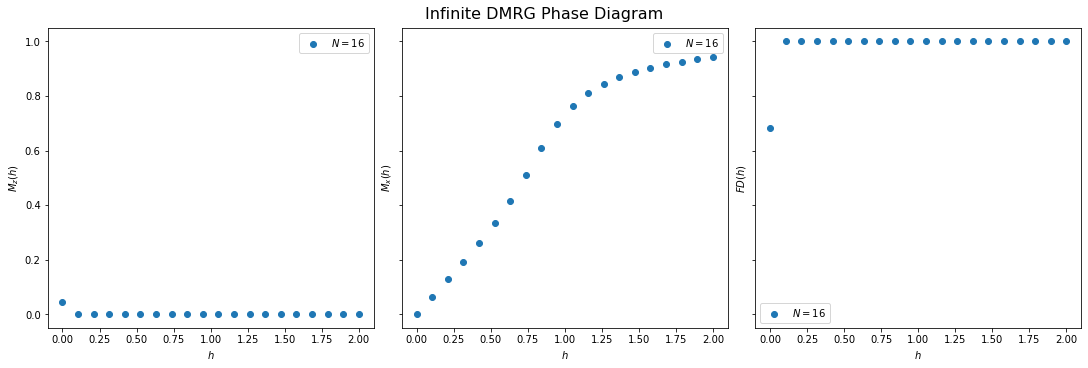

In [99]:
n = 16
fig, (fig_magz, fig_magx, fig_fd) = plt.subplots(1,3,figsize=(15, 5), constrained_layout=True, sharey=True)
fig_magz.scatter(h_arr,np.abs(magz_arr),label=r'$N= %d$'%n)
#fig_magz.set_title(r'M_(z)')
fig_magz.set_xlabel(r'$h$')
fig_magz.set_ylabel(r'$M_z(h)$')
fig_magz.legend()


fig_magx.scatter(h_arr,np.abs(magx_arr),label=r'$N= %d$'%n)
fig_magx.set_xlabel(r'$h$')
fig_magx.set_ylabel(r'$M_x(h)$')
#fig_magx.set_title('M_(x)')
fig_magx.legend()

# fig_ent_s.scatter(h_arr,np.abs(ent_s_arr),label=r'$N= %d$'%n)
# fig_ent_s.scatter(h_arr,np.log(2*np.ones(disc_point)),label=r'$ln2$')
# fig_ent_s.set_xlabel(r'$h$')
# fig_ent_s.set_ylabel(r'$S_{sys}(h)$')
# #fig_magx.set_title('M_(x)')
# fig_ent_s.legend()

fig_fd.scatter(h_arr,np.abs(fd_arr),label=r'$N= %d$'%n)
fig_fd.set_xlabel(r'$h$')
fig_fd.set_ylabel(r'$FD(h)$')
#fig_magx.set_title('M_(x)')
fig_fd.legend()

fig.suptitle('Infinite DMRG Phase Diagram', fontsize=16)
#plt.savefig('Infinite DMRG Phase Diagram N=%d.png'%n, dpi=300, bbox_inches='tight')

In [53]:
h_arr

array([0.        , 0.01578947, 0.03157895, 0.04736842, 0.06315789,
       0.07894737, 0.09473684, 0.11052632, 0.12631579, 0.14210526,
       0.15789474, 0.17368421, 0.18947368, 0.20526316, 0.22105263,
       0.23684211, 0.25263158, 0.26842105, 0.28421053, 0.3       ])